In [40]:
import wandb
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [223]:
api = wandb.Api()
runs = api.runs("saleml/hvi_paper_final")

In [224]:
interesting_runs = []
for run in runs:
    if run.state == 'finished':
        interesting_runs.append(run)
    # run.file("model.pt").download(replace=True)

In [225]:
groups = {}
for mode in ['tb', 'reverse_kl', 'rws', 'forward_kl', 'reverse_rws', 'modified_db']:
    for sampling_mode in ['on_policy', 'pure_off_policy']:
        for baseline in ['None', 'local', 'global']:
            for replay_capacity in [1000, 10000]:
                groups[f"{mode}_{sampling_mode}_{baseline}_{replay_capacity}"] = []
                for run in interesting_runs:
                    if run.config['mode'] == mode and run.config['sampling_mode'] == sampling_mode and run.config['baseline'] == baseline and run.config['replay_capacity'] == replay_capacity:
                        groups[f"{mode}_{sampling_mode}_{baseline}_{replay_capacity}"].append(run.history())


In [226]:
def get_group_average(group, column_name):
    "takes a list of dataframes as input and returns a numpy array of the average of the column across the dataframes"
    return np.mean(np.array([np.array(df[column_name].astype(float)) for df in group]), axis=0), np.std(np.array([np.array(df[column_name].astype(float)) for df in group]), axis=0)

In [227]:
average_jsd = {}
std_jsd = {}
states_visited = {}
average_modes_found = {}
std_modes_found = {}
for key in groups.keys():
    if len(groups[key]) > 0:
        average_jsd[key] = get_group_average(groups[key], 'jsd')[0]
        std_jsd[key] = get_group_average(groups[key], 'jsd')[1]
        states_visited[key] = get_group_average(groups[key], 'states_visited')[0]
        average_modes_found[key] = get_group_average(groups[key], 'modes_found')[0]
        std_modes_found[key] = get_group_average(groups[key], 'modes_found')[1]



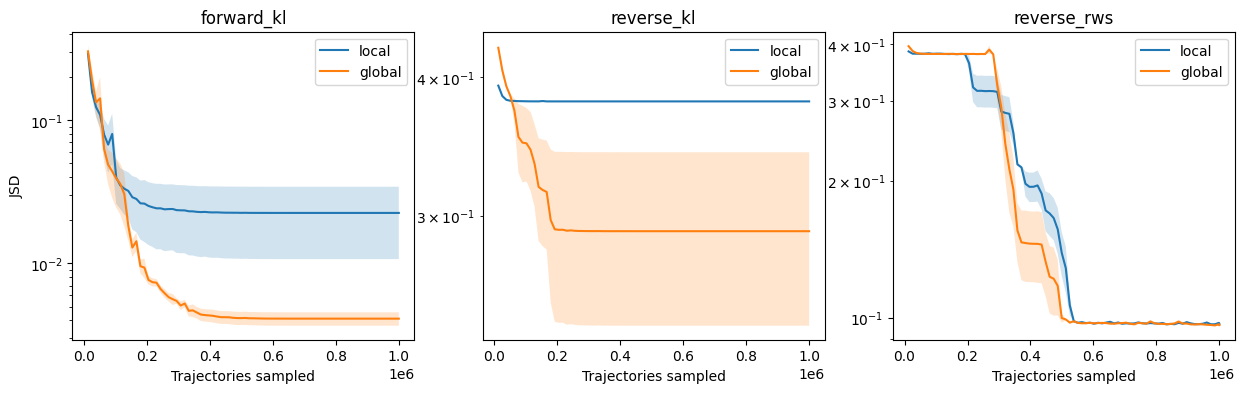

In [236]:
# Comparing the baseline for on-policy losses
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, mode in enumerate(['forward_kl', 'reverse_kl', 'reverse_rws']):
    for j, baseline in enumerate(['local', 'global']):
        group_name = f"{mode}_on_policy_{baseline}_1000"
        if group_name in average_jsd.keys():
            states_visited_j = states_visited[group_name]
            average_jsd_j = average_jsd[group_name]
            std_jsd_j = std_jsd[group_name]
            std_error_jsd_j = std_jsd_j / np.sqrt(len(groups[group_name]))
            axes[i].plot(states_visited_j, average_jsd_j, label=f"{baseline}")
            axes[i].fill_between(states_visited_j, average_jsd_j - std_error_jsd_j, average_jsd_j + std_error_jsd_j, alpha=0.2)
    axes[i].set_yscale('log')
    # axes[i].set_xscale('log')
    axes[i].set_title(f"{mode}")
    axes[i].set_xlabel("Trajectories sampled")
    if i == 0:
        axes[i].set_ylabel("JSD")
    axes[i].legend()
plt.savefig('importance_of_baseline_on_policy.pdf', bbox_inches='tight')
plt.show()

In [229]:
better_keys = {'tb': 'Trajectory Balance (GFN)', 'modified_db': 'Modified DB (GFN)',
 'forward_kl': 'Forward KL', 'reverse_kl': 'Reverse KL', 'reverse_rws': 'Reverse RWS', 'rws': 'RWS'}

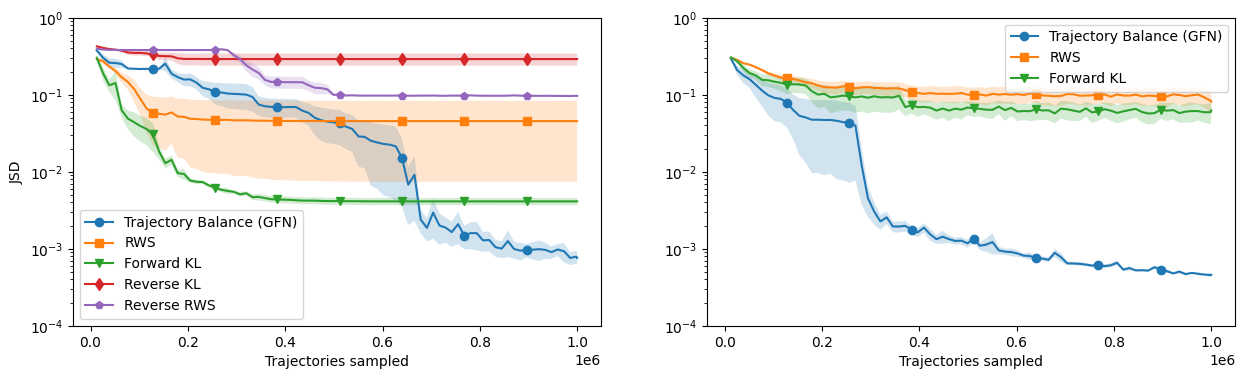

In [235]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
markers = ['o', 's', 'v', 'd', 'p', 'h', 'x', 'D', 'P', 'H', 'X']
for i, sampling_mode in enumerate(['on_policy', 'pure_off_policy']):
    for j, mode in enumerate(['tb', 'rws', 'forward_kl', 'reverse_kl', 'reverse_rws'] if sampling_mode == 'on_policy' else ['tb', 'rws', 'forward_kl']):
        baseline = 'global' if mode in ['forward_kl', 'reverse_kl', 'reverse_rws'] else 'None'
        group_name = f"{mode}_{sampling_mode}_{baseline}_1000"
        if group_name in average_jsd.keys():
            states_visited_j = states_visited[group_name]
            average_jsd_j = average_jsd[group_name]
            std_jsd_j = std_jsd[group_name]
            std_error_jsd_j = std_jsd_j / np.sqrt(len(groups[group_name]))
            axes[i].plot(states_visited_j, average_jsd_j, marker=markers[j], markevery=10, label=better_keys[mode])
            axes[i].fill_between(states_visited_j, average_jsd_j - std_error_jsd_j, average_jsd_j + std_error_jsd_j, alpha=0.2)
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-4, 1)
    # axes[i].set_xscale('log')
    # axes[i].set_title(f"{sampling_mode}")
    axes[i].set_xlabel("Trajectories sampled")
    if i == 0:
        axes[i].set_ylabel("JSD")
    axes[i].legend()
plt.savefig('comparing_all_modes.pdf', bbox_inches='tight')
plt.show()

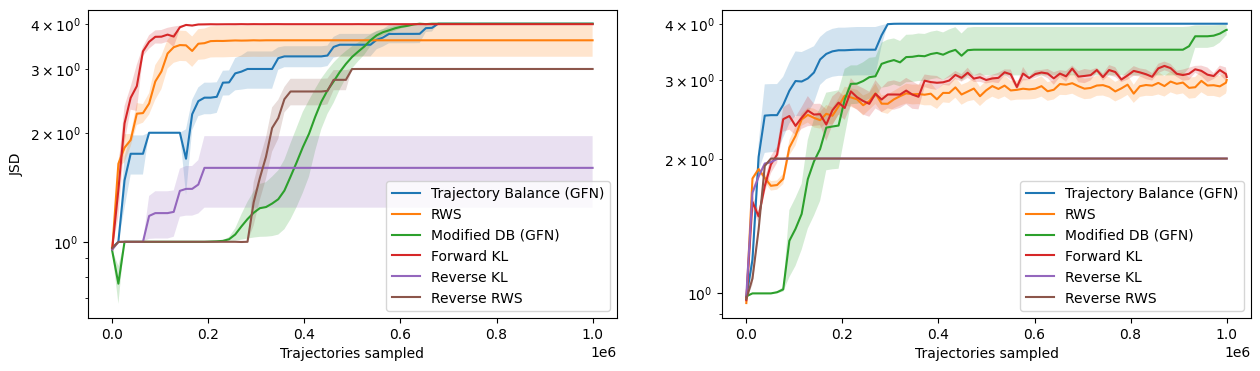

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
for i, sampling_mode in enumerate(['on_policy', 'pure_off_policy']):
    for j, mode in enumerate(['tb', 'rws', 'modified_db', 'forward_kl', 'reverse_kl', 'reverse_rws']):
        baseline = 'global' if mode in ['forward_kl', 'reverse_kl', 'reverse_rws'] else 'None'
        group_name = f"{mode}_{sampling_mode}_{baseline}_1000"
        if group_name in average_modes_found.keys():
            states_visited_j = states_visited[group_name]
            average_modes_found_j = average_modes_found[group_name]
            std_modes_found_j = std_modes_found[group_name]
            std_error_modes_found_j = std_modes_found_j / np.sqrt(len(groups[group_name]))
            axes[i].plot(states_visited_j, average_modes_found_j, label=better_keys[mode])
            axes[i].fill_between(states_visited_j, average_modes_found_j - std_error_modes_found_j, average_modes_found_j + std_error_modes_found_j, alpha=0.2)
    axes[i].set_yscale('log')
    # axes[i].set_xscale('log')
    # axes[i].set_title(f"{sampling_mode}")
    axes[i].set_xlabel("Trajectories sampled")
    if i == 0:
        axes[i].set_ylabel("JSD")
    axes[i].legend()
plt.show()

In [237]:
import os
for run in interesting_runs:
    if run.config['mode'] in ['reverse_kl', 'forward_kl', 'reverse_rws']:
        if run.config['baseline'] != 'global':
            continue
    if run.config['replay_capacity'] != 1000:
        continue
    iteration = max([int(x['path'].split('P_T_')[1].split('_')[0]) for x in run.history()['P_T'].values])
    name = f"{run.config['mode']}_{run.config['sampling_mode']}_{run.config['baseline']}_{run.config['replay_capacity']}_{run.config['seed']}"
    for file in run.files():
        if 'P_T' in file.name and str(iteration) in file.name:
            file.download(replace=True)
            file_directory = os.path.join(os.getcwd(), 'media', 'images')
            os.rename(file.name, os.path.join(file_directory, f"{name}.png"))



In [239]:
from PIL import Image
import os
import matplotlib

def filename_to_mode(filename):
    if 'forward_kl' in filename:
        return 'Forward KL'
    elif 'reverse_kl' in filename:
        return 'Reverse KL'
    elif 'reverse_rws' in filename:
        return 'Reverse RWS'
    elif 'modified_db' in filename:
        return 'Modified DB'
    elif 'tb' in filename:
        return 'Trajectory Balance'
    elif 'rws' in filename:
        return 'RWS'
    else:
        return 'Unknown'

def filename_to_sampling_mode(filename):
    if 'on_policy' in filename:
        return 'On-Policy'
    elif 'pure_off_policy' in filename:
        return 'Off-Policy'
    else:
        return 'Unknown'

files = os.listdir('media/images')
algs = [ f[:-4] for f in files ]
algos = {}
for image in files:
    key = filename_to_mode(image) + '_' + filename_to_sampling_mode(image)
    if key not in algos.keys():
        algos[key] = []
    image = np.array(Image.open(os.path.join('media/images', image))) / 255. 
    g = image[62:445:3,66:449:3]
    c = np.array(matplotlib.cm.viridis.colors)
    v = ((g[...,:3,None]-c.T)**2).sum(-2).argmin(-1) / 255.
    algos[key].append(v[::-1])

In [240]:
average_images = {key: np.array(val).mean(0) for key, val in algos.items()}

In [241]:
# target distribution
truev = np.copy(average_images['Trajectory Balance_Off-Policy'])
truev[(truev>0)*(truev<100/255.)] = 51/255.
truev[truev>51/255.]=1

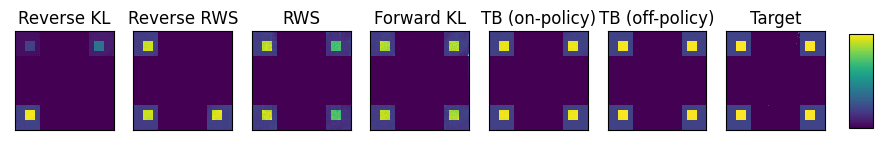

In [244]:
titles = {'Reverse KL_On-Policy': 'Reverse KL',
 'Reverse RWS_On-Policy': 'Reverse RWS',
 'RWS_On-Policy': 'RWS',
 'Forward KL_On-Policy': 'Forward KL',
 'Trajectory Balance_On-Policy': 'TB (on-policy)',
 'Trajectory Balance_Off-Policy': 'TB (off-policy)'}
plt.figure(figsize=(12, 2))
i = 1
for key in titles.keys():
    plt.subplot(1, 7, i)
    plt.xticks([]);plt.yticks([])
    plt.title(titles[key])
    plt.imshow(average_images[key], cmap='viridis', interpolation='none')
    i += 1
plt.subplot(1, 7, i)
plt.xticks([]);plt.yticks([])
plt.title('Target')
plt.imshow(truev, cmap='viridis', interpolation='none')
# add one colorbar for all subplots, and normalize the colors to [0, 1]
plt.subplots_adjust(right=0.8)
cbar_ax = plt.axes([0.82, 0.26, 0.02, 0.47])
plt.colorbar(cax=cbar_ax, ticks=[])
plt.savefig('final_distributions.pdf', bbox_inches='tight')
plt.show()
